# 0. import 모음

In [1]:
from google.colab import drive
import pandas as pd
import numpy as np
import os
from sklearn.model_selection import train_test_split
from tensorflow import keras
from keras.layers import LSTM
from keras.models import Sequential
from keras.layers import Dense
import keras.backend as K
from keras.callbacks import EarlyStopping
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score

# 1. 구글마운트

In [2]:
# drive.mount('/gdrive')

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


# 2. 데이터셋 만들기

## 데이터 위치로 이동

In [3]:
# %cd '/gdrive/MyDrive/EM_LSTM/data'

/gdrive/MyDrive/EM_LSTM/data


## file list 가져오기

In [4]:
path_dir = './'
file_list = os.listdir(path_dir)

## file 불러오기

In [5]:
em_x = []
em_y = []
for i in file_list :
  tempstr = './'+i
  em_x.append(np.array(pd.read_csv(tempstr)))
  #파일을 불러오면서 맨 앞 글자를 가져와 y 로 씀
  em_y.append(i[0])

- 파일 갯수 확인

In [6]:
print(len(em_x), len(em_y))

42 42


In [7]:
# 데이터를 다시 불러와야 하거나 로우데이터로 뭔가 확인을 해야할 수 있으므로 em_x 는 그대로 두고 em_x2 생성
# 하는 김에 np.array로 해서 shape 도 봄.
em_x2 = np.array(em_x)
em_x2[0].shape

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  This is separate from the ipykernel package so we can avoid doing imports until


(202, 7)

## y 값 인코딩

In [8]:
reshape_ha = list(em_y)

In [9]:
enc = {'a': 0, 'b': 1, 'c': 2}

In [10]:
lst_e = [enc[i] for i in reshape_ha]

- em_x 와 마찬가지로 em_y 보존을 위해 em_y2 생성

In [11]:
em_y2 = lst_e

### y 값 원핫 인코딩

In [12]:
ohe=np.eye( len(enc.keys() ))
ohe

array([[1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.]])

In [13]:
temp_elst = [ohe[i] for i in em_y2]

In [14]:
em_y2 = np.array(temp_elst)

# EDA

# 학습형태로 만들어주기
- 100개 씩 끊어서 LSTM 에서 학습할 수 있게 만들어 줌.

In [15]:
# 앞에서 끊어주기
# for 문을 통해 frames 단위로 학습을 하는 부분임.
npx = []
npy = []
frames = 100
for fileidx in range(0,len(em_x2)):
  # 파일당 최대 갯수를 지정(C 데이터가 158 이 max 인 파일이 있어서 150을 기준으로 잡음.)
  endpoint = 150
  for i in range(0,endpoint,1):
    # 100단위로 쪼개서 하기 위해 인덱스 지정
    idx = (i+frames) # i ~ idx 까지 잡아줌.
    idx2 = (idx+1)
    if idx2 >= endpoint :
      break;
    else:
      npx.append(np.array(em_x2[fileidx][i:idx]))
      npy.append(np.array(em_y2[fileidx]))
npx = np.array(npx)
npy = np.array(npy)
print(npx.shape, npy.shape)

(2058, 100, 7) (2058, 3)


In [17]:
npx.shape

(2058, 100, 7)

In [18]:
npy.shape

(2058, 3)

## 정답 분포 확인

In [19]:
pdy = pd.DataFrame(npy)
pdy.value_counts()

0    1    2  
1.0  0.0  0.0    686
0.0  1.0  0.0    686
     0.0  1.0    686
dtype: int64

## 셔플링

In [20]:
# shuffle = True
X_train, X_temptest, y_train, y_temptest = train_test_split(npx,  npy, 
                                                    test_size=0.0001, 
                                                    shuffle=True, 
                                                    random_state=1004)

In [21]:
print (len(X_train),len(X_temptest),len(y_train),len(y_temptest))

2057 1 2057 1


## TEST data 생성

In [22]:
%cd '/gdrive/MyDrive/EM_LSTM/test'

/gdrive/MyDrive/EM_LSTM/test


In [23]:
em_x2[0].shape[1]

7

In [24]:
path_dir = './'
file_list = os.listdir(path_dir)

In [25]:
em_x = []
em_y = []
for i in file_list :
  tempstr = './'+i
  em_x.append(np.array(pd.read_csv(tempstr)))
  #파일을 불러오면서 맨 앞 글자를 가져와 y 로 씀
  em_y.append(i[0])

In [26]:
# 데이터를 다시 불러와야 하거나 로우데이터로 뭔가 확인을 해야할 수 있으므로 em_x 는 그대로 두고 em_x2 생성
# 하는 김에 np.array로 해서 shape 도 봄.
em_x2 = np.array(em_x)
em_x2[0].shape

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  This is separate from the ipykernel package so we can avoid doing imports until


(431, 7)

In [27]:
reshape_ha = list(em_y)
new_list = []
for v in reshape_ha:
    if v not in new_list:
        new_list.append(v)

In [28]:
enc = {'a': 0, 'b': 1, 'c': 2}

In [29]:
lst_e = [enc[i] for i in reshape_ha]

In [30]:
em_y2 = lst_e

In [31]:
# 앞에서 끊어주기
# for 문을 통해 frames 단위로 학습을 하는 부분임.
npx = []
npy = []
frames = 100
for fileidx in range(0,len(em_x2)):
  endpoint = 150
  for i in range(0,endpoint,1):
    # 1 개씩 하는 것이 시간이 오래 걸리는 관계로 100단위로 쪼개서 하기 위해 인덱스 지정
    idx = (i+frames) # i ~ idx 까지 잡아줌.
    idx2 = (idx+1)
    if idx2 >= endpoint :
      break;
    else:
      npx.append(np.array(em_x2[fileidx][i:idx]))
      npy.append(np.array(em_y2[fileidx]))
npx = np.array(npx)
npy = np.array(npy)
print(npx.shape, npy.shape)

(147, 100, 7) (147,)


In [32]:
ohe=np.eye( len(enc.keys() ))

In [ ]:
temp_elst = [ohe[i] for i in npy]

In [34]:
npy = np.array(temp_elst)

In [35]:
# shuffle = True
from sklearn.model_selection import train_test_split
tempx_train, X_test, tempy_train, y_test = train_test_split(npx, npy, 
                                                    test_size=0.99, 
                                                    shuffle=True, 
                                                    random_state=1004)

In [36]:
print (len(tempx_train),len(X_test),len(tempy_train),len(y_test))

1 146 1 146


# 4. LSTM 모델 만들기

## 모델 구성
- 들어오는 데이터의 약 2배 이상의 히든레이어 생성
- y 값에 맞춰 3 개를 softmax 형태로 아웃풋 지정

In [37]:

K.clear_session()
model = Sequential() # Sequeatial Model 
model.add(LSTM(200, input_shape=( frames,  em_x2[0].shape[1]),activation='sigmoid')) # (timestep, feature) 
model.add(Dense(3,activation='softmax')) # output = 3
admax = keras.optimizers.Adamax(learning_rate=0.012, beta_1=0.95, beta_2=0.999, epsilon=None, decay=0.0)
model.compile(loss='mse', optimizer=admax)

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 200)               166400    
_________________________________________________________________
dense (Dense)                (None, 3)                 603       
Total params: 167,003
Trainable params: 167,003
Non-trainable params: 0
_________________________________________________________________


## 학습 실행

In [38]:
history = model.fit(X_train, y_train, batch_size=30, epochs=180, verbose=1, validation_data=(X_test, y_test))

Epoch 1/180
69/69 [==============================] - 15s 198ms/step - loss: 0.2938 - val_loss: 0.2786
Epoch 2/180
69/69 [==============================] - 13s 191ms/step - loss: 0.2564 - val_loss: 0.2248
Epoch 3/180
69/69 [==============================] - 13s 191ms/step - loss: 0.2219 - val_loss: 0.2247
Epoch 4/180
69/69 [==============================] - 13s 188ms/step - loss: 0.2195 - val_loss: 0.2262
Epoch 5/180
69/69 [==============================] - 13s 188ms/step - loss: 0.2146 - val_loss: 0.2400
Epoch 6/180
69/69 [==============================] - 13s 191ms/step - loss: 0.2002 - val_loss: 0.2673
Epoch 7/180
69/69 [==============================] - 13s 189ms/step - loss: 0.1870 - val_loss: 0.2616
Epoch 8/180
69/69 [==============================] - 13s 186ms/step - loss: 0.1837 - val_loss: 0.2638
Epoch 9/180
69/69 [==============================] - 13s 189ms/step - loss: 0.1777 - val_loss: 0.2787
Epoch 10/180
69/69 [==============================] - 14s 197ms/step - loss: 0.186

## 모델 저장

In [39]:
%cd '/gdrive/MyDrive/EM_LSTM'
model.save('./emo.h5')

/gdrive/MyDrive/EM_LSTM
/gdrive/MyDrive/EM_LSTM


# 평가

## 학습 History

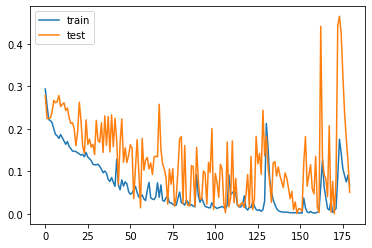

In [40]:
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

## Predict 진행

In [41]:
y_true = np.array(y_test)
x_scaled = np.array(X_test)

In [42]:
y_pred = model.predict(x_scaled)

## argmax 로 예측된 값 정리

In [43]:
y_pred2 = np.argmax(y_pred, axis=1)
y_true2 = np.argmax(y_true, axis=1)

## Confusion matrix

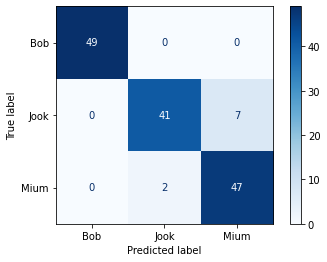

In [44]:
labels = ["Bob", "Jook", "Mium"]

cm = confusion_matrix(y_true2, y_pred2)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)

disp.plot(cmap=plt.cm.Blues)
plt.show()

## Accuracy

In [45]:
print(accuracy_score(y_true2, y_pred2))

0.9383561643835616
